<a href="https://colab.research.google.com/github/volodymyr-d/Holacracy-Constitution-4.1-RUSSIAN/blob/master/Football_QLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install:
# Kaggle environments.
!git clone https://github.com/Kaggle/kaggle-environments.git
!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v2.7 https://github.com/google-research/football.git
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.7.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install . 

# Install Gym
!pip install gym

!pip install tqm

from IPython.display import clear_output
clear_output()

In [ ]:
import gfootball
import gym
import numpy as np
import tensorflow as tf
import random
from collections import deque
import numpy as np
import seaborn as sns
import pandas as pd
import gym
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

  
  
def show_state(env, step=0):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='ipython'))
    plt.title("%s. Step: %d" % (env._spec.id,step))
    
    plt.pause(0.001)  # pause for plots to update

    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
  
  
env = gym.make("GFootball-11_vs_11_kaggle-SMM-v0")
next_state, reward, done, info = env.step(5)
env.render(mode='ipython')
print(next_state)

In [2]:
import gfootball
import gym
import numpy as np
import tensorflow as tf
import random
from collections import deque
import numpy as np
import seaborn as sns
import pandas as pd
import gym
import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def plot(data, window=100):
    sns.lineplot(
        data=data.rolling(window=window).mean()[window-1::window]
    )

class ReplayBuffer:
    def __init__(self, size=1000000):
        self.memory = deque(maxlen=size)
        
    def remember(self, s_t, a_t, r_t, s_t_next, d_t):
        self.memory.append((s_t, a_t, r_t, s_t_next, d_t))
        
    def sample(self,batch_size):
        batch_size = min(batch_size, len(self.memory))
        return random.sample(self.memory,batch_size)


class SplitLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, inputs):
        split0,split1,split2,split3 = tf.split(inputs,4,3)
        return [split0,split1,split2,split3]

class ConvNN:

    def __init__(self,state_shape,num_actions):
        self.state_shape = state_shape
        self.num_actions = num_actions

    def _model_architecture(self):
    
        frames_input = tf.keras.layers.Input(shape=self.state_shape,name='input',batch_size=3)
        frames_split = SplitLayer()(frames_input)
        conv_branches = []
        for f,frame in enumerate(frames_split):
            conv_branches.append(self._build_conv_branch(frame,f))

        concat = tf.keras.layers.concatenate(conv_branches)
        
        fc0 = tf.keras.layers.Dense(units=8192, name='fc0', 
                                     activation='relu')(concat)
        fc1 = tf.keras.layers.Dense(units=2048, name='fc1', 
                                     activation='relu')(fc0)
        fc2 = tf.keras.layers.Dense(units=512, name='fc2', 
                                     activation='relu')(fc1)
        fc3 = tf.keras.layers.Dense(units=256, name='fc3', 
                                     activation='relu')(fc2)
        fc4 = tf.keras.layers.Dense(units=64, name='fc4', 
                                     activation='relu')(fc3)
        
        action_output = tf.keras.layers.Dense(units=self.num_actions, name='output',
                                               activation='relu')(fc4)
        return frames_input,action_output
        
    @staticmethod
    def _build_conv_branch(frame,number):
        conv1 = tf.keras.layers.Conv2D(16, kernel_size=(8, 8), strides=(4, 4),
                                        name='conv1_frame'+str(number), padding='same',
                                        activation='relu')(frame)
        mp1 = tf.keras.layers.MaxPooling2D(pool_size=2, name="mp1_frame"+str(number))(conv1)
        conv2 = tf.keras.layers.Conv2D(24, kernel_size=(4, 4), strides=(2, 2),
                                        name='conv2_frame'+str(number),padding='same',
                                        activation='relu')(mp1)
        mp2 = tf.keras.layers.MaxPooling2D(pool_size=2, name="mp2_frame"+str(number))(conv2)
        conv3 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                                        name='conv3_frame'+str(number),padding='same',
                                        activation='relu')(mp2)
        mp3 = tf.keras.layers.MaxPooling2D(pool_size=2, name="mp3_frame"+str(number))(conv3)
        conv4 = tf.keras.layers.Conv2D(64, kernel_size=(2, 2), strides=(1, 1),
                                        name='conv4_frame'+str(number), padding='same',
                                        activation='relu')(mp3)
        mp4 = tf.keras.layers.MaxPooling2D(pool_size=1, name="mp4_frame"+str(number))(conv4)

        flatten = tf.keras.layers.Flatten(name='flatten'+str(number))(mp4)

        return flatten
        
    def build(self):
        frames_input,action_output = self._model_architecture()
        model = tf.keras.Model(inputs=[frames_input], outputs=[action_output])
        return model

class Agent:
    def __init__(self, state_shape, num_actions,alpha, gamma, epsilon_i=1.0, epsilon_f=0.01, n_epsilon=0.1):
        self.epsilon_i = epsilon_i
        self.epsilon_f = epsilon_f
        self.n_epsilon = n_epsilon
        self.epsilon = epsilon_i
        self.gamma = gamma
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.optimizer = tf.keras.optimizers.Adam(alpha) 

        self.Q = ConvNN(state_shape,num_actions).build()
        self.Q_ = ConvNN(state_shape,num_actions).build()
        
    def synchronize(self):
        self.Q_.set_weights(self.Q.get_weights())

    def act(self, s_t):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.num_actions,size=3)
        return np.argmax(self.Q(s_t), axis=1)
    
    def decay_epsilon(self, n):
        self.epsilon = max(
            self.epsilon_f, 
            self.epsilon_i - (n/self.n_epsilon)*(self.epsilon_i - self.epsilon_f))

    def update(self, s_t, a_t, r_t, s_t_next, d_t):
        with tf.GradientTape() as tape:
            Q_next = tf.stop_gradient(tf.reduce_max(self.Q_(s_t_next), axis=1))
            Q_pred = tf.reduce_sum(self.Q(s_t)*tf.one_hot(a_t, self.num_actions, dtype=tf.float32), axis=1)
            loss = tf.reduce_mean(0.5*(r_t + (1-d_t)*self.gamma*Q_next - Q_pred)**2)
        grads = tape.gradient(loss, self.Q.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.Q.trainable_variables))

class VectorizedEnvWrapper(gym.Wrapper):
    def __init__(self, make_env, num_envs=1):
        super().__init__(make_env())
        self.num_envs = num_envs
        self.envs = [make_env() for env_index in range(num_envs)]
    
    def reset(self):
        return np.asarray([env.reset() for env in self.envs])
    
    def reset_at(self, env_index):
        return self.envs[env_index].reset()
    
    def step(self, actions):
        next_states, rewards, dones, infos = [], [], [], []
        for env, action in zip(self.envs, actions):
            next_state, reward, done, info = env.step(action)
            next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
            infos.append(info)
        return np.asarray(next_states), np.asarray(rewards), \
            np.asarray(dones), np.asarray(infos)

class NormalizationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def observation(self, obs):
        return obs/255

train_agent = Agent((72,96,4),19,alpha=0.1,gamma=0.95)
train_agent.Q.save_weights("QWeights")
train_agent.Q_.save_weights("Q_Weights")
smm_env = VectorizedEnvWrapper(lambda: NormalizationWrapper(gym.make("GFootball-11_vs_11_kaggle-SMM-v0")), 3)
train_buffer = ReplayBuffer()      


def train(env=smm_env,T=3001,batch_size=3,sync_every=10,agent=train_agent,buffer=train_buffer):
    
    agent.Q.load_weights("QWeights")
    agent.Q_.load_weights("Q_Weights")
    rewards = []
    episode_rewards = 0
    s_t = env.reset()
    start = time.time()
    for t in range(T):
        if t%sync_every == 0:
            agent.synchronize()
        a_t = agent.act(s_t)
        s_t_next, r_t, d_t, info = env.step(a_t)
        buffer.remember(s_t, a_t, r_t, s_t_next, d_t)
        for batch in buffer.sample(batch_size):
            agent.update(*batch)
        agent.decay_epsilon(t/T)
        episode_rewards += r_t
                  
        for i in range(env.num_envs): 
            if d_t[i]:
                rewards.append(episode_rewards[i])   
                episode_rewards[i] = 0
                s_t[i] = env.reset_at(i)

       # if t % 100 == 0 and False:
       #   print(t)
       #   done = time.time()
       #   print(done - start)
       #   start = done
       #   print(rewards)
        
    agent.epsilon_i = 1.0
    agent.epsilon_f = 0.01
    agent.n_epsilon = 0.1
    agent.epsilon = agent.epsilon_i
    
    return rewards

print("Start")
#rewards = train()
#plot(pd.DataFrame(rewards), window=10)
train_agent.Q.save_weights("QWeights") 

Start


In [5]:
from kaggle_environments import make
from tqdm import tqdm
import gym
from typing import Union, Callable, List, Tuple, Iterable, Any, Dict

env = make("football", configuration={"save_video": True, "scenario_name": "5_vs_5", "running_in_notebook": True})

env.reset()
steps = 0
for x in (range(50)):
  a1 = 5
  a2 = 0
  obs, rew = env.step([[a1], [a2]])
  print(obs)
  break
  print(rew)
  print(obs['observation']['players_raw'][0]['ball'])
  print(obs['observation']['players_raw'][0]['ball_owned_player'])
  print(obs['observation']['players_raw'][0]['ball_owned_team'])
  print(obs['observation']['players_raw'][0]['right_team'])
  print(obs['observation']['players_raw'][0]['left_team'])
  break
  if env.done:
    break
env.render(mode="human", width=800, height=600)

{'action': [5], 'reward': 0, 'info': {}, 'observation': {'controlled_players': 1, 'players_raw': [{'left_team_roles': [0, 7, 9, 2, 1], 'right_team_roles': [0, 7, 9, 2, 1], 'left_team_active': [True, True, True, True, True], 'ball_owned_team': -1, 'left_team': [[-1.010373830795288, 5.1467219375211926e-11], [-0.03912772238254547, 0.03933045640587807], [-0.03837660700082779, -0.04043374955654144], [-0.10096431523561478, -0.10212276875972748], [-0.10228612273931503, 0.1027330681681633]], 'left_team_direction': [[0.0026071772444993258, 1.9680050644677038e-10], [0.0020699903834611177, -0.0020807438995689154], [0.0034561052452772856, 0.0003092596889473498], [0.0004270497593097389, -0.0016366465715691447], [-0.00195687310770154, 0.0018260125070810318]], 'ball_rotation': [0.0, -0.0, 0.0], 'right_team_direction': [[-0.0, 0.0], [-8.568439846534659e-10, 0.002478683367371559], [-0.0, 0.0], [-0.0, 0.0], [-0.0, 0.0]], 'ball': [0.0, -0.0, 0.11059734225273132], 'right_team_active': [True, True, True, T

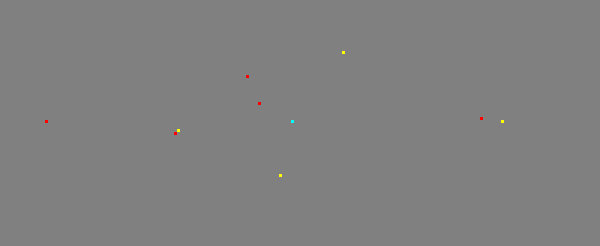

KeyboardInterrupt: ignored

In [10]:
import numpy as np
from PIL import Image, ImageDraw
from kaggle_environments import make
from tqdm import tqdm
import gym
from typing import Union, Callable, List, Tuple, Iterable, Any, Dict
from google.colab import output


def convert(point):
    return int(point[0] * 100) + 98, int(point[1] * 100) + 41

def get_field(obs):
    ball_owned_player = obs['observation']['players_raw'][0]['ball_owned_player']
    ball_owned_team = obs['observation']['players_raw'][0]['ball_owned_team']
    ball = obs['observation']['players_raw'][0]['ball']
    right_team = obs['observation']['players_raw'][0]['right_team']
    left_team = obs['observation']['players_raw'][0]['left_team']
    field = np.zeros((200, 82))

    for i, player in enumerate(left_team):
      mark = 1
      if ball_owned_player == i and ball_owned_team == 0:
        mark = 5
      point = convert(player)
      field[point[0]][point[1]] = mark

    for i, player in enumerate(right_team):
      mark = 2
      point = convert(player)
      field[point[0]][point[1]] = mark

    point = convert((ball[0], ball[1]))
    field[point[0]][point[1]] = 3 
    return field

def render(field):
    s = 3
    im = Image.new('RGB', (200*s, 82*s), (128, 128, 128))
    draw = ImageDraw.Draw(im)     
    for x in range(200):
      for y in range(82):
        color = (128, 128, 128)
        if field[x][y] == 1:
          color = (255, 0, 0)
        if field[x][y] == 2:
          color = (255, 255, 0)
        if field[x][y] == 3:
          color = (0, 255, 255)
        if field[x][y] == 5:
          color = (0, 255, 0)                 
        draw.rectangle(((x-1)*s, (y-1)*s, (x+1)*s, (y+1)*s), fill=color)  
    
    output.clear(output_tags='some_outputs')
    with output.use_tags('some_outputs'):
      display(im)

env = make("football", configuration={"save_video": True, "scenario_name": "5_vs_5", "running_in_notebook": True})
env.reset()
steps = 0
for x in (range(5000)):
  a1 = 5
  a2 = 0
  obs, rew = env.step([[a1], [a2]])
  field = get_field(obs)
  render(field)
  if env.done:
    break


